[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/conditional_redshift_example.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow

-------------------
## Redshift example

This notebook uses the same data as the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb), but this time, instead of modeling the full 7-dimensional probability distribution, we will model the distribution of redshifts, conditioned on the magnitudes.

Note that this just a basic 1-dimensional example, but it is also possible to condition a high-dimesional distribution on multiple variables. For example, you might build the 7-dimensional flow from the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb), but condition the flow on right ascension and declination.

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt

from pzflow import Flow
from pzflow.bijectors import Chain, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import get_galaxy_data

import pandas as pd

First let's load the example galaxy data set included with `pzflow`.

In [3]:
# load the galaxy data
data = get_galaxy_data()
data.head()

,redshift,u,g,r,i,z,y
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


Now we must construct the bijector. 
It will be very similar to the bijector from the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb). 

To understand why this bijector is different you have to understand the difference between data variables (i.e. redshift) and conditional variables (i.e. the colors).
The data variables are the variables that are subject to the bijector, which is conditioned on the conditional variables.
In this flow, we will draw a single latent variable from a univariate Gaussian, apply the bijection, conditioned on the colors, to that single variable, and as a result, we will get a redshift.
The bijection is conditioned on the *ugrizy* magnitudes, but the magnitudes do not have the bijection applied to them.
In other words:
$$ \sigma \sim \mathcal{N}(0,1) \quad \text{and} \quad \text{redshift} = f(\sigma| \, u, g, r, i, z, y).$$

Since we are only transforming one variable, let's only use a single layer of the Rolling Spline Coupling.
However, there is one very important change we must make!
We must set `n_conditions = 6`, because we are conditioning on 6 variables (i.e. u, g, r, i, z, y)

In [5]:
# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviation of the redshifts
means = data['redshift'].mean()
stds = data['redshift'].std()

# construct our bijector
# by chaining all these layers
bijector = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers=1, n_conditions=6),
)

Now we instantiate the Flow.
This is identical to before, except now we must differentiate between `data_columns` and `conditional_columns`.

In [6]:
# To create the conditional flow, we have to provide
# 1. The names of the data columns
# 2. The bijector
# 3. The names of the conditional columns
flow = Flow(data.columns[:1], bijector, conditional_columns=data.columns[1:])

Now we can train our normalizing flow in the exact same way as before.

In [7]:
%%time
losses = flow.train(data, epochs=125, verbose=True)

Training 125 epochs 
Loss:
(0) 0.8816
(1) -0.3766
(7) -1.3737
(13) -1.8210
(19) -2.0013
(25) -2.2527
(31) -2.4032
(37) -2.4712
(43) -2.5812
(49) -2.6878
(55) -2.7639
(61) -2.7107
(67) -2.8615
(73) -2.8751
(79) -2.9825
(85) -2.9824
(91) -3.0107
(97) -3.0882
(103) -3.0475
(109) -2.8756
(115) -2.9025
(121) -3.1734
(125) -3.1120
CPU times: user 40.2 s, sys: 43.8 s, total: 1min 23s
Wall time: 29.7 s


Now let's plot the training losses to make sure everything looks like we expect it to...

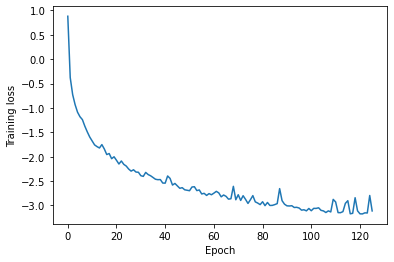

In [8]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Great!

You can use this conditional flow in essentially the same way as the non-conditional flows.
For example, you can calculate posteriors:

In [9]:
galaxy = data[:1]
grid = np.arange(0, 2.02, 0.02)
pdf = flow.posterior(galaxy, column="redshift", grid=grid)

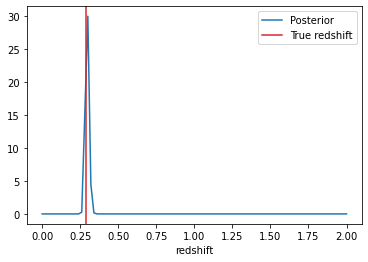

In [10]:
plt.plot(grid, pdf[0], label='Posterior')
plt.axvline(galaxy['redshift'][0], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.show()

We can also sample from the flow, but the key difference is that now we must provide conditions on which to condition the samples. In addition, `nsamples` controls how many times each condition is sampled from. So for example, if we take the first 500 conditions in our data set, and set `nsamples = 4`, we will get 2000 samples.

In [11]:
# draw 4 samples for each of the first 500 conditions
samples = flow.sample(4, conditions=data[:500], seed=0)
print(samples.shape)

(2000, 7)


In [12]:
# lets print the first 10
# see how conditions 0-3 are the same?
# and 4-7? etc.
samples[:10]

,redshift,u,g,r,i,z,y
0,0.298494,26.759260,25.901777,25.187710,24.932318,24.736902,24.671623
1,0.292876,26.759260,25.901777,25.187710,24.932318,24.736902,24.671623
2,0.278755,26.759260,25.901777,25.187710,24.932318,24.736902,24.671623
3,0.297940,26.759260,25.901777,25.187710,24.932318,24.736902,24.671623
4,0.271918,27.428358,26.679298,25.977161,25.700094,25.522762,25.417631
5,0.346170,27.428358,26.679298,25.977161,25.700094,25.522762,25.417631
6,0.299497,27.428358,26.679298,25.977161,25.700094,25.522762,25.417631
7,0.304283,27.428358,26.679298,25.977161,25.700094,25.522762,25.417631
8,1.394503,27.294001,26.068798,25.450054,24.460506,23.887220,23.206112
9,1.392877,27.294001,26.068798,25.450054,24.460506,23.887220,23.206112


Let's draw one sample for each condition, to make sure that our samples match the data distribution

In [13]:
samples = flow.sample(1, conditions=data, seed=0)

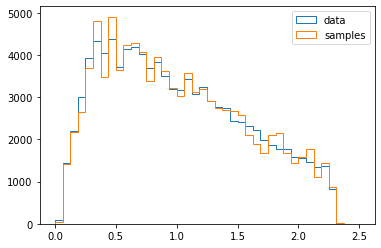

In [14]:
plt.hist(data['redshift'], range=(0, 2.5), bins=40, histtype='step', label='data')
plt.hist(samples['redshift'], range=(0, 2.5), bins=40, histtype='step', label='samples')
plt.legend()
plt.show()

Perfect!